In [1]:
import pandas as pd
import openml
from openml.datasets import edit_dataset, fork_dataset, get_dataset

data = openml.datasets.get_dataset(41156)

X, y, categorical_indicator, attribute_names = data.get_data(
    target=data.default_target_attribute, dataset_format="dataframe"
)

In [2]:
nominal = [b for a, b in zip(categorical_indicator, attribute_names) if a]
dummied_data = pd.get_dummies(X, columns=nominal)

columns = dummied_data.columns
updates = {}
for col in columns:
    if any(x in col for x in set(('[', ']', '=', '>', '<', ' ', '/', '(', ')', '-', '?'))):
        updates[col] = col.replace('?', '_').replace('-', '_').replace(')', '_').replace('(', '_').replace(' ', '_').replace(',', '_').replace('[', '_').replace(']', '_').replace('<', 'less').replace('>', 'greater').replace('=', 'equal').replace('/', '_')
dummied_data = dummied_data.rename(columns=updates)

dummied_data.fillna(0, inplace=True)
dummied_data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48
0,0,1,1,32.0,0,0,0,1,0,0.0,...,0,404.0,1,0,0,0,0,0,0,0
1,0,0,1,133.0,0,0,1,0,0,0.0,...,0,242.0,0,0,0,0,0,0,0,0
2,0,0,0,109.0,0,0,0,1,0,0.0,...,0,404.0,1,0,0,0,0,0,0,0
3,0,0,0,113.0,0,0,0,1,0,0.0,...,0,404.0,0,0,0,1,0,1,0,0
4,0,0,0,120.0,0,0,0,1,0,0.0,...,0,303.0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4142,0,0,0,50.0,1,0,0,1,1,0.0,...,0,404.0,0,0,0,0,0,0,0,1
4143,0,0,0,144.0,0,0,0,1,1,0.0,...,0,404.0,1,0,0,0,0,0,0,0
4144,0,0,0,129.0,0,0,0,0,0,0.0,...,0,353.0,1,1,0,0,0,0,0,0
4145,0,0,0,225.0,0,0,1,1,0,0.0,...,0,303.0,0,0,0,0,0,0,0,0


In [3]:
y

0       0
1       0
2       0
3       1
4       0
       ..
4142    0
4143    0
4144    0
4145    0
4146    1
Name: class, Length: 4147, dtype: category
Categories (2, object): ['0' < '1']

In [4]:
mapping = {'1': 1, '0': 0}
y = y.replace(mapping)

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, left_out, y_train, y_left_out = train_test_split(dummied_data, y, test_size=0.4, random_state=42)
X_test, X_dev, y_test, y_dev = train_test_split(left_out, y_left_out, test_size=0.5, random_state=42)

print(f'train shape: {X_train.shape}\n test shape: {X_test.shape}\n dev shape: {X_dev.shape}')

train shape: (2488, 48)
 test shape: (829, 48)
 dev shape: (830, 48)


In [6]:
drop_list = [col for col in X_train.columns if sum(X_train[col]) <= 0]

X_train.drop(drop_list, axis=1, inplace=True)
X_test.drop(drop_list, axis=1, inplace=True)
X_dev.drop(drop_list, axis=1, inplace=True)
print(f'{len(drop_list)} columns dropped')
print(f'train shape: {X_train.shape}\n test shape: {X_test.shape}\n dev shape: {X_dev.shape}')

2 columns dropped
train shape: (2488, 46)
 test shape: (829, 46)
 dev shape: (830, 46)


In [29]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

xg_boost = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False)

clf = GridSearchCV(xg_boost,{'learning_rate': [1.0, 0.1, 0.01, 0.001],
                        'max_depth': [70000],
                        'n_estimators': [100, 250, 500],
                       'reg_lambda': [10, 1, 0.1, 0.01, 0.001]}, 
                        verbose=2, 
                        error_score='raise')

clf.fit(X_train, y_train)
print(clf.best_score_, clf.best_params_)
xgb_clf = clf

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[15:49:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=1.0, max_depth=70000, n_estimators=100, reg_lambda=10; total time=   0.0s
[15:49:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=1.0, max_depth=70000, n_estimators=100, reg_lambda=10; total time=   0.0s
[15:49:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the ol

[CV] END learning_rate=1.0, max_depth=70000, n_estimators=100, reg_lambda=0.001; total time=   0.0s
[15:49:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=1.0, max_depth=70000, n_estimators=250, reg_lambda=10; total time=   0.1s
[15:49:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=1.0, max_depth=70000, n_estimators=250, reg_lambda=10; total time=   0.1s
[15:49:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_

[CV] END learning_rate=1.0, max_depth=70000, n_estimators=500, reg_lambda=10; total time=   0.1s
[15:49:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=1.0, max_depth=70000, n_estimators=500, reg_lambda=10; total time=   0.1s
[15:49:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=1.0, max_depth=70000, n_estimators=500, reg_lambda=10; total time=   0.1s
[15:49:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_met

[CV] END learning_rate=0.1, max_depth=70000, n_estimators=100, reg_lambda=10; total time=   0.0s
[15:50:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=70000, n_estimators=100, reg_lambda=1; total time=   0.0s
[15:50:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=70000, n_estimators=100, reg_lambda=1; total time=   0.0s
[15:50:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metri

[CV] END learning_rate=0.1, max_depth=70000, n_estimators=250, reg_lambda=10; total time=   0.1s
[15:50:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=70000, n_estimators=250, reg_lambda=10; total time=   0.1s
[15:50:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=70000, n_estimators=250, reg_lambda=1; total time=   0.1s
[15:50:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metr

[CV] END learning_rate=0.1, max_depth=70000, n_estimators=500, reg_lambda=10; total time=   0.2s
[15:50:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=70000, n_estimators=500, reg_lambda=10; total time=   0.1s
[15:50:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=70000, n_estimators=500, reg_lambda=10; total time=   0.2s
[15:50:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_met

[CV] END learning_rate=0.01, max_depth=70000, n_estimators=100, reg_lambda=10; total time=   0.1s
[15:50:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=70000, n_estimators=100, reg_lambda=1; total time=   0.0s
[15:50:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=70000, n_estimators=100, reg_lambda=1; total time=   0.0s
[15:50:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_me

[CV] END learning_rate=0.01, max_depth=70000, n_estimators=250, reg_lambda=10; total time=   0.1s
[15:50:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=70000, n_estimators=250, reg_lambda=10; total time=   0.1s
[15:50:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=70000, n_estimators=250, reg_lambda=1; total time=   0.1s
[15:50:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_m

[CV] END learning_rate=0.01, max_depth=70000, n_estimators=500, reg_lambda=10; total time=   0.2s
[15:50:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=70000, n_estimators=500, reg_lambda=10; total time=   0.2s
[15:50:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=70000, n_estimators=500, reg_lambda=10; total time=   0.2s
[15:50:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_

[CV] END learning_rate=0.001, max_depth=70000, n_estimators=100, reg_lambda=10; total time=   0.1s
[15:50:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.001, max_depth=70000, n_estimators=100, reg_lambda=1; total time=   0.0s
[15:50:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.001, max_depth=70000, n_estimators=100, reg_lambda=1; total time=   0.1s
[15:50:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval

[CV] END learning_rate=0.001, max_depth=70000, n_estimators=250, reg_lambda=10; total time=   0.1s
[15:50:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.001, max_depth=70000, n_estimators=250, reg_lambda=10; total time=   0.1s
[15:50:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.001, max_depth=70000, n_estimators=250, reg_lambda=1; total time=   0.1s
[15:50:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[CV] END learning_rate=0.001, max_depth=70000, n_estimators=500, reg_lambda=10; total time=   0.2s
[15:50:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.001, max_depth=70000, n_estimators=500, reg_lambda=10; total time=   0.2s
[15:50:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.001, max_depth=70000, n_estimators=500, reg_lambda=10; total time=   0.2s
[15:50:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set ev

[15:27:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB test_acc: 0.8528347406513872
recall: 0.78938225505317
precision: 0.7958226839711886
f_score: 0.7925084934924256



/home/amak2/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


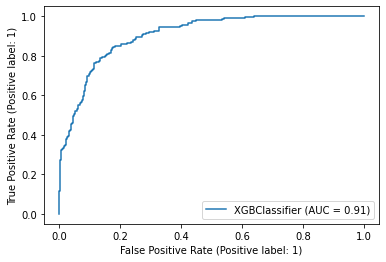

In [7]:
import xgboost as xgb
from sklearn.metrics import f1_score, precision_score, recall_score
from helper_func import plot_roc

xg_boost = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, 
                             learning_rate=0.1, max_depth=7000, n_estimators= 250, reg_lambda=1)


xgb_clf = xg_boost.fit(X_train, y_train)
test_ac = xgb_clf.score(X_test, y_test)
pred = xgb_clf.predict(X_test)
f_score = f1_score(y_test, pred, average='macro')
prec = precision_score(y_test, pred, average='macro')
recall = recall_score(y_test, pred, average='macro')

print(f'XGB test_acc: {test_ac}\nrecall: {recall}\nprecision: {prec}\nf_score: {f_score}\n')
plot_roc(xgb_clf, X_test, y_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


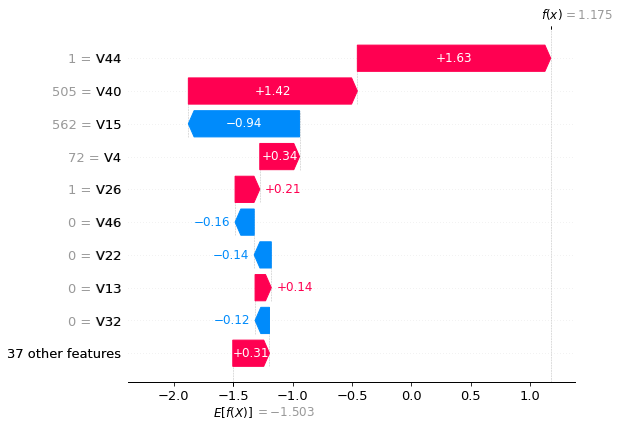

In [8]:
import shap

explainer = shap.Explainer(xgb_clf)
shap_values = explainer(X_dev, check_additivity=False)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [9]:
from multiprocessing import Pool, cpu_count, Queue
from helper_func import *

num_cores = cpu_count()
print(f'num of cores: {num_cores}')
        
if len(intervals_dict) == 0:
        compute_intervals(intervals_dict, X_train)


num of cores: 16


In [10]:
from mlxtend.frequent_patterns import apriori, association_rules
from tqdm import tqdm
import math

pred = xgb_clf.predict(X_dev)

pos_label = '1'
neg_label = '0'

itemset = set()
encoded_vals = []
summed_values = {}
shap_threshold = 0.001


p = Pool(num_cores)

for feature in X_train.columns.to_list():
    if feature in intervals_dict:
        intervals = intervals_dict[feature]
        for interval in intervals:
            if interval != interval: continue
            left = interval.left
            right = interval.right
            name = f'{left}<{feature}<={right}'
            itemset.add(name)
    else:
        itemset.add(feature)

itemset.add(pos_label)
itemset.add(neg_label)

for indx in tqdm(range(len(pred))):
    
    pos_queue.put(pos_label)
    neg_queue.put(neg_label)
    
    zipped = zip(shap_values[indx].values.tolist(), shap_values[indx].data.tolist(), 
         shap_values.feature_names, [shap_threshold]*len(shap_values.feature_names))

    p.map(get_relevant_features, zipped)
    
    append_to_encoded_vals(pos_queue, itemset, encoded_vals)
    append_to_encoded_vals(neg_queue, itemset, encoded_vals)

ohe_df = pd.DataFrame(encoded_vals)



100%|██████████| 830/830 [00:07<00:00, 114.60it/s]


In [11]:
freq_items = apriori(ohe_df, min_support=(10/len(pred)), use_colnames=True, max_len=3)
all_rules = association_rules(freq_items, metric="confidence", min_threshold=0.7, support_only=False)

freq_items = apriori(ohe_df.loc[ohe_df[pos_label] == 1], min_support=(10/len(pred)), use_colnames=True, max_len=3)
pos_rules = association_rules(freq_items, metric="confidence", min_threshold=0.7, support_only=False)

freq_items = apriori(ohe_df.loc[ohe_df[neg_label] == 1], min_support=(10/len(pred)), use_colnames=True, max_len=3)
neg_rules = association_rules(freq_items, metric="confidence", min_threshold=0.7, support_only=False)

In [12]:
positive = all_rules[all_rules['consequents'] == {pos_label}]
positive = positive[positive['confidence'] == 1]
positive = positive.sort_values(['confidence', 'support'], ascending=[False, False])

seen = set()
dropped = set()
indexes_to_drop = []

positive = positive.reset_index(drop=True)
print(len(positive))
for i in positive.index:
    new_rule = positive.loc[[i]]['antecedents'].values[0]
    
    for seen_rule in seen:
        if seen_rule.issubset(new_rule):#new_rule.issubset(seen_rule) or seen_rule.issubset(new_rule):
            indexes_to_drop.append(i)
            break
    else:
        seen.add(new_rule)

positive.drop(positive.index[indexes_to_drop], inplace=True )
print(len(positive))

390
104


In [13]:
negative = all_rules[all_rules['consequents'] == {neg_label}]
negative = negative[negative['confidence'] == 1]

negative = negative.sort_values(['confidence', 'support'], ascending=[False, False])

seen = set()
dropped = set()
indexes_to_drop = []

negative = negative.reset_index(drop=True)
print(len(negative))
for i in negative.index:
    new_rule = negative.loc[[i]]['antecedents'].values[0]
    
    for seen_rule in seen:
        if seen_rule.issubset(new_rule):#new_rule.issubset(seen_rule) or seen_rule.issubset(new_rule):
            indexes_to_drop.append(i)
            break
    else:
        seen.add(new_rule)

negative.drop(negative.index[indexes_to_drop], inplace=True )
print(len(negative))

157
83


In [14]:
positive['num-items'] = positive['antecedents'].map(lambda x: len(x))
negative['num-items'] = negative['antecedents'].map(lambda x: len(x))
positive['consequents'] = positive['consequents'].map(lambda x: pos_label)
negative['consequents'] = negative['consequents'].map(lambda x: neg_label)

both = positive.append(negative, ignore_index=True)

discr_rules = both[['antecedents', 'consequents', 'num-items', 'support', 'confidence', 'antecedent support']].sort_values(
    ['support', 'confidence', 'num-items'], ascending=[False, False, False])

discr_rules = discr_rules.rename(columns={"antecedents": "itemset", "consequents": "label"})

discr_rules

,itemset,label,num-items,support,confidence,antecedent support
0,(V44),1,1,0.500000,1.0,0.500000
1,(V26),1,1,0.500000,1.0,0.500000
2,(V12),1,1,0.500000,1.0,0.500000
3,(V29),1,1,0.500000,1.0,0.500000
4,(V18),1,1,0.500000,1.0,0.500000
...,...,...,...,...,...,...
183,"(V35, 513.0<V25<=675.0)",0,2,0.014458,1.0,0.014458
103,"(V3, 603.4<V40<=801.2)",1,2,0.013855,1.0,0.013855
184,"(V17, 513.0<V25<=675.0)",0,2,0.013253,1.0,0.013253
185,"(V45, 624.2<V15<=811.6)",0,2,0.013253,1.0,0.013253


In [15]:
rev_positive = pos_rules[pos_rules['antecedents'] == {pos_label}]
rev_positive = rev_positive[rev_positive['confidence'] >= 0.8]
rev_positive = rev_positive.sort_values(['confidence', 'support'], ascending=[False, False])

seen = set()
dropped = set()
indexes_to_drop = []

rev_positive = rev_positive.reset_index(drop=True)
print(len(rev_positive))
for i in rev_positive.index:
    new_rule = rev_positive.loc[[i]]['consequents'].values[0]
    
    for seen_rule, indx in seen:
        if seen_rule.issubset(new_rule):
            indexes_to_drop.append(i)
            break
    else:
        seen.add((new_rule, i))

rev_positive.drop(rev_positive.index[indexes_to_drop], inplace=True )
print(len(rev_positive))



rev_negative = neg_rules[neg_rules['antecedents'] == {neg_label}]
rev_negative = rev_negative[rev_negative['confidence'] >= 0.8]
rev_negative = rev_negative.sort_values(['confidence', 'support'], ascending=[False, False])

seen = set()
dropped = set()
indexes_to_drop = []

rev_negative = rev_negative.reset_index(drop=True)
print(len(rev_negative))
for i in rev_negative.index:
    new_rule = rev_negative.loc[[i]]['consequents'].values[0]
    
    for seen_rule, indx in seen:
        if seen_rule.issubset(new_rule):
            indexes_to_drop.append(i)
            break
    else:
        seen.add((new_rule, i))

rev_negative.drop(rev_negative.index[indexes_to_drop], inplace=True )
print(len(rev_negative))

130
16
30
8


In [16]:
rev_positive['num-items'] = rev_positive['consequents'].map(lambda x: len(x))
rev_negative['num-items'] = rev_negative['consequents'].map(lambda x: len(x))
rev_positive['antecedents'] = rev_positive['antecedents'].map(lambda x: pos_label)
rev_negative['antecedents'] = rev_negative['antecedents'].map(lambda x: neg_label)

rev_both = rev_positive.append(rev_negative, ignore_index=True)

chr_rules = rev_both[['antecedents', 'consequents', 'num-items', 'support', 
                          'confidence', 'consequent support']].sort_values(
    ['support', 'confidence', 'num-items'], ascending=[False, False, False])

chr_rules = chr_rules.rename(columns={"antecedents": "label", "consequents": "itemset"})

chr_rules

,label,itemset,num-items,support,confidence,consequent support
0,1,(V44),1,1.000000,1.000000,1.000000
1,1,(V26),1,1.000000,1.000000,1.000000
2,1,(V12),1,1.000000,1.000000,1.000000
3,1,(V29),1,1.000000,1.000000,1.000000
4,1,(V18),1,1.000000,1.000000,1.000000
16,0,(V23),1,1.000000,1.000000,1.000000
17,0,(V42),1,0.996386,0.996386,0.996386
18,0,(V5),1,0.996386,0.996386,0.996386
5,1,(V46),1,0.995181,0.995181,0.995181
19,0,(V35),1,0.993976,0.993976,0.993976


100%|██████████| 829/829 [00:03<00:00, 270.21it/s]
Acc: 0.8492159227985525
macro rules recall: 0.8066393932353039
macro rules prec: 0.7833824138407031
macro rules f1_score: 0.7937158225189662
188 211


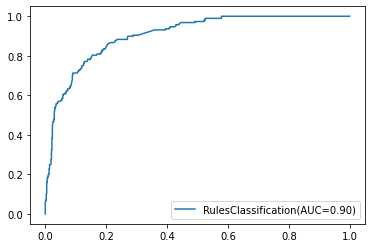

[0.5192024715557041]
coverage: 0.991556091676719


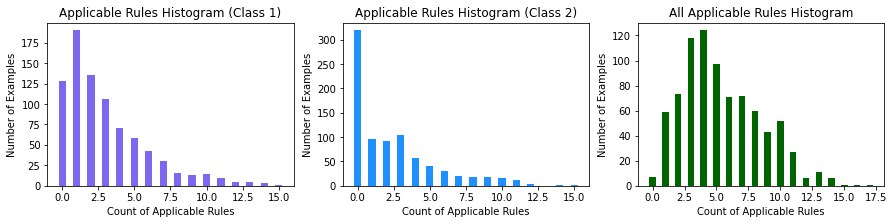

In [17]:
from rules_model import *

dev_pred = xgb_clf.predict(X_dev)
rules_model = RulesModel(ohe_df, discr_rules, y_dev, pos_label, neg_label)

test_pred = xgb_clf.predict(X_test)
rules_test_sol = rules_model.eval_rules(X_test, test_pred, alpha=10, beta =len(discr_rules), decision_thr=0.61)

100%|██████████| 829/829 [00:02<00:00, 327.98it/s]
Acc: 0.8781664656212304
macro rules recall: 0.8347578583994424
macro rules prec: 0.8240136863072672
macro rules f1_score: 0.829161098132033
188 197


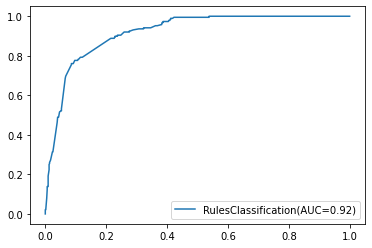

[0.9987744679803127]
coverage: 1.00


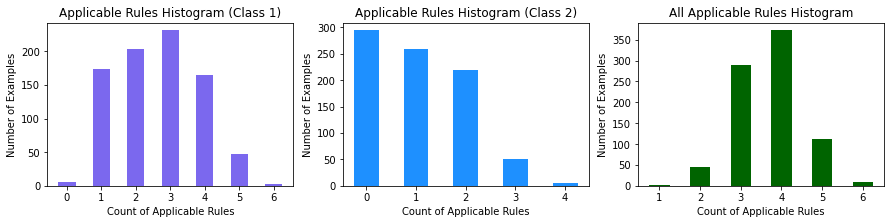

In [20]:
rules_model = RulesModel(ohe_df, chr_rules, y_dev, pos_label, neg_label)

test_pred = xgb_clf.predict(X_test)
rules_test_sol = rules_model.eval_rules(X_test, test_pred, alpha=35, beta=1, decision_thr=0.99987)